# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
#from mlfs import config
#settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/karen/mlfs-book


In [2]:
import datetime
from datetime import timedelta
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util
import os

In [3]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
yesterday = today - datetime.timedelta(days = 1)
before_yesterday = today - datetime.timedelta(days = 2)
before_2_yesterday = today - datetime.timedelta(days = 3)

print(tomorrow, yesterday, before_yesterday, before_2_yesterday)

2025-11-17 19:27:42.052905 2025-11-15 19:27:42.052905 2025-11-14 19:27:42.052905 2025-11-13 19:27:42.052905


## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [4]:
project = hopsworks.login(engine="python")
secrets = hopsworks.get_secrets_api()
fs = project.get_feature_store() 
aqicn_url = "https://api.waqi.info/feed/A98194/"
AQICN_API_KEY = secrets.get_secret("AQICN_API_KEY").value
secrets = hopsworks.get_secrets_api()

# Sensor 1
location_str_sensor_1 = secrets.get_secret("SENSOR1_LOCATION_JSON").value
location_1 = json.loads(location_str_sensor_1)
street_1=location_1['street']

# Sensor 2
location_str_sensor_2 = secrets.get_secret("SENSOR2_LOCATION_JSON").value
location_2 = json.loads(location_str_sensor_2)
street_2=location_2['street']

# Sensor 3
location_str_sensor_3 = secrets.get_secret("SENSOR3_LOCATION_JSON").value
location_3 = json.loads(location_str_sensor_3)
street_3=location_3['street']

# Sensor 4
location_str_sensor_4 = secrets.get_secret("SENSOR4_LOCATION_JSON").value
location_4 = json.loads(location_str_sensor_4)
street_4=location_4['street']

# General information
country=location_1['country']
city=location_1['city']

2025-11-16 19:27:42,055 INFO: Initializing external client
2025-11-16 19:27:42,055 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-16 19:27:42,807 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-16 19:27:43,704 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1279151


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

### Sensor 1

In [6]:
mr_sensor1 = project.get_model_registry()

retrieved_model_s1 = mr_sensor1.get_model(
    name="air_quality_xgboost_model_with_lags_sensor_1",
    version=7,
)

fv_s1 = retrieved_model_s1.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir_s1 = retrieved_model_s1.download()

2025-11-16 19:28:25,617 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/1657626 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/860836 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/105408 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/38025 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/109107 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/24714 elapsed<00:00 remaining<?

In [7]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model_s1 = XGBRegressor()

retrieved_xgboost_model_s1.load_model(saved_model_dir_s1 + "/model_1.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model_s1

XGBRegressor(base_score='6.6810946E0', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Sensor 2

In [8]:
mr_sensor2 = project.get_model_registry()

retrieved_model_s2 = mr_sensor2.get_model(
    name="air_quality_xgboost_model_with_lags_sensor_2",
    version=4,
)

fv_s2 = retrieved_model_s2.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir_s2 = retrieved_model_s2.download()

2025-11-16 19:28:52,226 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/797503 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/450201 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/112127 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/37517 elapsed<00:00 remaining<?

In [9]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model_s2 = XGBRegressor()

retrieved_xgboost_model_s2.load_model(saved_model_dir_s2 + "/model_2.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model_s2

XGBRegressor(base_score='8.254004E0', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Sensor 3

In [10]:
mr_sensor3 = project.get_model_registry()

retrieved_model_s3 = mr_sensor3.get_model(
    name="air_quality_xgboost_model_with_lags_sensor_3",
    version=9,
)

fv_s3 = retrieved_model_s3.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir_s3 = retrieved_model_s3.download()

2025-11-16 19:29:18,900 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/1567992 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/1567992 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/113069 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/37086 elapsed<00:00 remaining<?

In [11]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model_s3 = XGBRegressor()

retrieved_xgboost_model_s3.load_model(saved_model_dir_s3 + "/model_3.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model_s3

XGBRegressor(base_score='7.863733E0', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Sensor 4

In [12]:
mr_sensor4 = project.get_model_registry()

retrieved_model_s4 = mr_sensor4.get_model(
    name="air_quality_xgboost_model_with_lags_sensor_4",
    version=4,
)

fv_s4 = retrieved_model_s4.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir_s4 = retrieved_model_s4.download()

2025-11-16 19:29:36,232 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/872562 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/1474544 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/114639 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/36003 elapsed<00:00 remaining<?

In [13]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model_s4 = XGBRegressor()

retrieved_xgboost_model_s4.load_model(saved_model_dir_s4 + "/model_4.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model_s4

XGBRegressor(base_score='5.497835E0', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [14]:
#Sensor 1
aq_fg_s1 = fs.get_feature_group(
    name='air_quality_lagged_sensor_1',
    version=1,
)

#Sensor 2
aq_fg_s2 = fs.get_feature_group(
    name='air_quality_lagged_sensor_2',
    version=1,
)

#Sensor 3
aq_fg_s3 = fs.get_feature_group(
    name='air_quality_lagged_sensor_3',
    version=1,
)

#Sensor 4
aq_fg_s4 = fs.get_feature_group(
    name='air_quality_lagged_sensor_4',
    version=1,
)

# We keep the same weather for the 4 sensors as it is the same city
weather_fg = fs.get_feature_group(
    name='weather_sensor',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data = batch_data.sort_values(by="date", ascending=True)
batch_data = batch_data.reset_index(drop=True)
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.73s) 


,date,temperature_2m_mean,apparent_temperature_mean,dewpoint_2m_mean,precipitation_sum,rain_sum,snowfall_sum,wind_speed_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration,city
0,2025-11-17 00:00:00+00:00,19.200001,17.112673,12.694678,0.1,0.1,0.0,20.124611,222.825241,370.0,0.234400,rome
1,2025-11-18 00:00:00+00:00,16.299999,16.742821,12.260189,0.3,0.3,0.0,1.800000,360.000000,274.0,0.154788,rome
2,2025-11-19 00:00:00+00:00,12.950000,11.919285,9.766445,1.2,1.2,0.0,6.725354,344.475830,225.0,0.118642,rome
3,2025-11-20 00:00:00+00:00,13.450000,11.935459,12.175789,0.7,0.7,0.0,15.038350,168.959106,118.0,0.065327,rome
4,2025-11-21 00:00:00+00:00,9.300000,7.006087,8.539822,2.2,2.2,0.0,13.104198,344.054535,93.0,0.045752,rome
5,2025-11-22 00:00:00+00:00,15.600000,12.885321,12.161602,2.1,2.1,0.0,23.233252,130.601212,201.0,0.122916,rome


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

### Sensor 1

#### Auto regresive model

In [15]:
aq_df_s1 = aq_fg_s1.read().sort_values(by="date")

# Copy the weather dataframe for this sensor
batch_data_s1 = batch_data.copy()

# Grab the first row for predictions
weather_tomorrow = batch_data_s1.head(1)

batch_data_s1.loc[0, 'lag_1'] = float('nan')
batch_data_s1.loc[0, 'lag_2'] = float('nan')
batch_data_s1.loc[0, 'lag_3'] = float('nan')
batch_data_s1

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.98s) 


,date,temperature_2m_mean,apparent_temperature_mean,dewpoint_2m_mean,precipitation_sum,rain_sum,snowfall_sum,wind_speed_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration,city,lag_1,lag_2,lag_3
0,2025-11-17 00:00:00+00:00,19.200001,17.112673,12.694678,0.1,0.1,0.0,20.124611,222.825241,370.0,0.234400,rome,NaN,NaN,NaN
1,2025-11-18 00:00:00+00:00,16.299999,16.742821,12.260189,0.3,0.3,0.0,1.800000,360.000000,274.0,0.154788,rome,NaN,NaN,NaN
2,2025-11-19 00:00:00+00:00,12.950000,11.919285,9.766445,1.2,1.2,0.0,6.725354,344.475830,225.0,0.118642,rome,NaN,NaN,NaN
3,2025-11-20 00:00:00+00:00,13.450000,11.935459,12.175789,0.7,0.7,0.0,15.038350,168.959106,118.0,0.065327,rome,NaN,NaN,NaN
4,2025-11-21 00:00:00+00:00,9.300000,7.006087,8.539822,2.2,2.2,0.0,13.104198,344.054535,93.0,0.045752,rome,NaN,NaN,NaN
5,2025-11-22 00:00:00+00:00,15.600000,12.885321,12.161602,2.1,2.1,0.0,23.233252,130.601212,201.0,0.122916,rome,NaN,NaN,NaN


In [17]:
# Set the lag values
lag_1 = aq_df_s1.iloc[-1]['lag_1'].astype('float32')
lag_2 = aq_df_s1.iloc[-1]['lag_2'].astype('float32')
lag_3 = aq_df_s1.iloc[-1]['lag_3'].astype('float32')

# List to save predictions
predictions = []

# Features columns
feature_columns = ['lag_1', 'lag_2', 'lag_3',
     'temperature_2m_mean',
     'apparent_temperature_mean',
     'dewpoint_2m_mean',
     'precipitation_sum',
     'rain_sum',
     'snowfall_sum',
     'wind_speed_10m_max',
     'wind_direction_10m_dominant',
     'shortwave_radiation_sum',
     'et0_fao_evapotranspiration']

for i in range(len(batch_data)):
    # Assign lags to each day
    batch_data_s1.loc[i, 'lag_1'] = lag_1
    batch_data_s1.loc[i, 'lag_2'] = lag_2
    batch_data_s1.loc[i, 'lag_3'] = lag_3

    X_row = batch_data_s1.loc[[i], feature_columns]
    pm25_pred = float(retrieved_xgboost_model_s1.predict(X_row)[0])

    # Save prediction
    batch_data_s1.loc[i, 'predicted_pm25'] = pm25_pred

    # Update lags
    lag_3, lag_2, lag_1 = lag_2, lag_1, pm25_pred

In [18]:
batch_data_s1['predicted_pm25'] = batch_data_s1['predicted_pm25'].astype('float32')
batch_data_s1['lag_1'] = batch_data_s1['lag_1'].astype('float32')
batch_data_s1['lag_2'] = batch_data_s1['lag_2'].astype('float32')
batch_data_s1['lag_3'] = batch_data_s1['lag_3'].astype('float32')

batch_data_s1

,date,temperature_2m_mean,apparent_temperature_mean,dewpoint_2m_mean,precipitation_sum,rain_sum,snowfall_sum,wind_speed_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration,city,lag_1,lag_2,lag_3,predicted_pm25
0,2025-11-17 00:00:00+00:00,19.200001,17.112673,12.694678,0.1,0.1,0.0,20.124611,222.825241,370.0,0.234400,rome,9.750000,8.880000,12.630000,9.306096
1,2025-11-18 00:00:00+00:00,16.299999,16.742821,12.260189,0.3,0.3,0.0,1.800000,360.000000,274.0,0.154788,rome,9.306096,9.750000,8.880000,12.394120
2,2025-11-19 00:00:00+00:00,12.950000,11.919285,9.766445,1.2,1.2,0.0,6.725354,344.475830,225.0,0.118642,rome,12.394120,9.306096,9.750000,13.155504
3,2025-11-20 00:00:00+00:00,13.450000,11.935459,12.175789,0.7,0.7,0.0,15.038350,168.959106,118.0,0.065327,rome,13.155504,12.394120,9.306096,11.790811
4,2025-11-21 00:00:00+00:00,9.300000,7.006087,8.539822,2.2,2.2,0.0,13.104198,344.054535,93.0,0.045752,rome,11.790811,13.155504,12.394120,11.060733
5,2025-11-22 00:00:00+00:00,15.600000,12.885321,12.161602,2.1,2.1,0.0,23.233252,130.601212,201.0,0.122916,rome,11.060733,11.790811,13.155504,9.870335


### Sensor 2

#### Auto regresive model

In [20]:
aq_df_s2 = aq_fg_s2.read().sort_values(by="date")

# Copy the weather dataframe for this sensor
batch_data_s2 = batch_data.copy()

# Grab the first row for predictions
weather_tomorrow = batch_data_s2.head(1)

batch_data_s2.loc[0, 'lag_1'] = float('nan')
batch_data_s2.loc[0, 'lag_2'] = float('nan')
batch_data_s2.loc[0, 'lag_3'] = float('nan')
batch_data_s2

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.04s) 


,date,temperature_2m_mean,apparent_temperature_mean,dewpoint_2m_mean,precipitation_sum,rain_sum,snowfall_sum,wind_speed_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration,city,lag_1,lag_2,lag_3
0,2025-11-17 00:00:00+00:00,19.200001,17.112673,12.694678,0.1,0.1,0.0,20.124611,222.825241,370.0,0.234400,rome,NaN,NaN,NaN
1,2025-11-18 00:00:00+00:00,16.299999,16.742821,12.260189,0.3,0.3,0.0,1.800000,360.000000,274.0,0.154788,rome,NaN,NaN,NaN
2,2025-11-19 00:00:00+00:00,12.950000,11.919285,9.766445,1.2,1.2,0.0,6.725354,344.475830,225.0,0.118642,rome,NaN,NaN,NaN
3,2025-11-20 00:00:00+00:00,13.450000,11.935459,12.175789,0.7,0.7,0.0,15.038350,168.959106,118.0,0.065327,rome,NaN,NaN,NaN
4,2025-11-21 00:00:00+00:00,9.300000,7.006087,8.539822,2.2,2.2,0.0,13.104198,344.054535,93.0,0.045752,rome,NaN,NaN,NaN
5,2025-11-22 00:00:00+00:00,15.600000,12.885321,12.161602,2.1,2.1,0.0,23.233252,130.601212,201.0,0.122916,rome,NaN,NaN,NaN


In [21]:
# Set the lag values
lag_1 = aq_df_s2.iloc[-1]['lag_1'].astype('float32')
lag_2 = aq_df_s2.iloc[-1]['lag_2'].astype('float32')
lag_3 = aq_df_s2.iloc[-1]['lag_3'].astype('float32')

# List to save predictions
predictions = []

# Features columns
feature_columns = ['lag_1', 'lag_2', 'lag_3',
     'temperature_2m_mean',
     'apparent_temperature_mean',
     'dewpoint_2m_mean',
     'precipitation_sum',
     'rain_sum',
     'snowfall_sum',
     'wind_speed_10m_max',
     'wind_direction_10m_dominant',
     'shortwave_radiation_sum',
     'et0_fao_evapotranspiration']

for i in range(len(batch_data)):
    # Assign lags to each day
    batch_data_s2.loc[i, 'lag_1'] = lag_1
    batch_data_s2.loc[i, 'lag_2'] = lag_2
    batch_data_s2.loc[i, 'lag_3'] = lag_3

    X_row = batch_data_s2.loc[[i], feature_columns]
    pm25_pred = float(retrieved_xgboost_model_s2.predict(X_row)[0])

    # Save prediction
    batch_data_s2.loc[i, 'predicted_pm25'] = pm25_pred

    # Update lags
    lag_3, lag_2, lag_1 = lag_2, lag_1, pm25_pred

In [22]:
batch_data_s2['predicted_pm25'] = batch_data_s2['predicted_pm25'].astype('float32')
batch_data_s2['lag_1'] = batch_data_s2['lag_1'].astype('float32')
batch_data_s2['lag_2'] = batch_data_s2['lag_2'].astype('float32')
batch_data_s2['lag_3'] = batch_data_s2['lag_3'].astype('float32')

batch_data_s2

,date,temperature_2m_mean,apparent_temperature_mean,dewpoint_2m_mean,precipitation_sum,rain_sum,snowfall_sum,wind_speed_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration,city,lag_1,lag_2,lag_3,predicted_pm25
0,2025-11-17 00:00:00+00:00,19.200001,17.112673,12.694678,0.1,0.1,0.0,20.124611,222.825241,370.0,0.234400,rome,11.450000,11.930000,15.180000,16.410137
1,2025-11-18 00:00:00+00:00,16.299999,16.742821,12.260189,0.3,0.3,0.0,1.800000,360.000000,274.0,0.154788,rome,16.410137,11.450000,11.930000,20.716335
2,2025-11-19 00:00:00+00:00,12.950000,11.919285,9.766445,1.2,1.2,0.0,6.725354,344.475830,225.0,0.118642,rome,20.716335,16.410137,11.450000,38.461746
3,2025-11-20 00:00:00+00:00,13.450000,11.935459,12.175789,0.7,0.7,0.0,15.038350,168.959106,118.0,0.065327,rome,38.461746,20.716335,16.410137,21.797419
4,2025-11-21 00:00:00+00:00,9.300000,7.006087,8.539822,2.2,2.2,0.0,13.104198,344.054535,93.0,0.045752,rome,21.797419,38.461746,20.716335,22.584515
5,2025-11-22 00:00:00+00:00,15.600000,12.885321,12.161602,2.1,2.1,0.0,23.233252,130.601212,201.0,0.122916,rome,22.584515,21.797419,38.461746,20.530846


### Sensor 3

#### Auto regresive model

In [23]:
aq_df_s3 = aq_fg_s3.read().sort_values(by="date")

# Copy the weather dataframe for this sensor
batch_data_s3 = batch_data.copy()

# Grab the first row for predictions
weather_tomorrow = batch_data_s3.head(1)

batch_data_s3.loc[0, 'lag_1'] = float('nan')
batch_data_s3.loc[0, 'lag_2'] = float('nan')
batch_data_s3.loc[0, 'lag_3'] = float('nan')
batch_data_s3

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.10s) 


,date,temperature_2m_mean,apparent_temperature_mean,dewpoint_2m_mean,precipitation_sum,rain_sum,snowfall_sum,wind_speed_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration,city,lag_1,lag_2,lag_3
0,2025-11-17 00:00:00+00:00,19.200001,17.112673,12.694678,0.1,0.1,0.0,20.124611,222.825241,370.0,0.234400,rome,NaN,NaN,NaN
1,2025-11-18 00:00:00+00:00,16.299999,16.742821,12.260189,0.3,0.3,0.0,1.800000,360.000000,274.0,0.154788,rome,NaN,NaN,NaN
2,2025-11-19 00:00:00+00:00,12.950000,11.919285,9.766445,1.2,1.2,0.0,6.725354,344.475830,225.0,0.118642,rome,NaN,NaN,NaN
3,2025-11-20 00:00:00+00:00,13.450000,11.935459,12.175789,0.7,0.7,0.0,15.038350,168.959106,118.0,0.065327,rome,NaN,NaN,NaN
4,2025-11-21 00:00:00+00:00,9.300000,7.006087,8.539822,2.2,2.2,0.0,13.104198,344.054535,93.0,0.045752,rome,NaN,NaN,NaN
5,2025-11-22 00:00:00+00:00,15.600000,12.885321,12.161602,2.1,2.1,0.0,23.233252,130.601212,201.0,0.122916,rome,NaN,NaN,NaN


In [24]:
# Set the lag values
lag_1 = aq_df_s3.iloc[-1]['lag_1'].astype('float32')
lag_2 = aq_df_s3.iloc[-1]['lag_2'].astype('float32')
lag_3 = aq_df_s3.iloc[-1]['lag_3'].astype('float32')

# List to save predictions
predictions = []

# Features columns
feature_columns = ['lag_1', 'lag_2', 'lag_3',
     'temperature_2m_mean',
     'apparent_temperature_mean',
     'dewpoint_2m_mean',
     'precipitation_sum',
     'rain_sum',
     'snowfall_sum',
     'wind_speed_10m_max',
     'wind_direction_10m_dominant',
     'shortwave_radiation_sum',
     'et0_fao_evapotranspiration']

for i in range(len(batch_data)):
    # Assign lags to each day
    batch_data_s3.loc[i, 'lag_1'] = lag_1
    batch_data_s3.loc[i, 'lag_2'] = lag_2
    batch_data_s3.loc[i, 'lag_3'] = lag_3

    X_row = batch_data_s3.loc[[i], feature_columns]
    pm25_pred = float(retrieved_xgboost_model_s4.predict(X_row)[0])

    # Save prediction
    batch_data_s3.loc[i, 'predicted_pm25'] = pm25_pred

    # Update lags
    lag_3, lag_2, lag_1 = lag_2, lag_1, pm25_pred

In [25]:
batch_data_s3['predicted_pm25'] = batch_data_s3['predicted_pm25'].astype('float32')
batch_data_s3['lag_1'] = batch_data_s3['lag_1'].astype('float32')
batch_data_s3['lag_2'] = batch_data_s3['lag_2'].astype('float32')
batch_data_s3['lag_3'] = batch_data_s3['lag_3'].astype('float32')

batch_data_s3

,date,temperature_2m_mean,apparent_temperature_mean,dewpoint_2m_mean,precipitation_sum,rain_sum,snowfall_sum,wind_speed_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration,city,lag_1,lag_2,lag_3,predicted_pm25
0,2025-11-17 00:00:00+00:00,19.200001,17.112673,12.694678,0.1,0.1,0.0,20.124611,222.825241,370.0,0.234400,rome,9.590000,7.300000,6.870000,8.399110
1,2025-11-18 00:00:00+00:00,16.299999,16.742821,12.260189,0.3,0.3,0.0,1.800000,360.000000,274.0,0.154788,rome,8.399110,9.590000,7.300000,14.793151
2,2025-11-19 00:00:00+00:00,12.950000,11.919285,9.766445,1.2,1.2,0.0,6.725354,344.475830,225.0,0.118642,rome,14.793151,8.399110,9.590000,13.746976
3,2025-11-20 00:00:00+00:00,13.450000,11.935459,12.175789,0.7,0.7,0.0,15.038350,168.959106,118.0,0.065327,rome,13.746976,14.793151,8.399110,9.772479
4,2025-11-21 00:00:00+00:00,9.300000,7.006087,8.539822,2.2,2.2,0.0,13.104198,344.054535,93.0,0.045752,rome,9.772479,13.746976,14.793151,7.225973
5,2025-11-22 00:00:00+00:00,15.600000,12.885321,12.161602,2.1,2.1,0.0,23.233252,130.601212,201.0,0.122916,rome,7.225973,9.772479,13.746976,7.681974


### Sensor 4

#### Auto regresive model

In [26]:
aq_df_s4 = aq_fg_s4.read().sort_values(by="date")

# Copy the weather dataframe for this sensor
batch_data_s4 = batch_data.copy()

# Grab the first row for predictions
weather_tomorrow = batch_data_s4.head(1)

batch_data_s4.loc[0, 'lag_1'] = float('nan')
batch_data_s4.loc[0, 'lag_2'] = float('nan')
batch_data_s4.loc[0, 'lag_3'] = float('nan')
batch_data_s4

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.19s) 


,date,temperature_2m_mean,apparent_temperature_mean,dewpoint_2m_mean,precipitation_sum,rain_sum,snowfall_sum,wind_speed_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration,city,lag_1,lag_2,lag_3
0,2025-11-17 00:00:00+00:00,19.200001,17.112673,12.694678,0.1,0.1,0.0,20.124611,222.825241,370.0,0.234400,rome,NaN,NaN,NaN
1,2025-11-18 00:00:00+00:00,16.299999,16.742821,12.260189,0.3,0.3,0.0,1.800000,360.000000,274.0,0.154788,rome,NaN,NaN,NaN
2,2025-11-19 00:00:00+00:00,12.950000,11.919285,9.766445,1.2,1.2,0.0,6.725354,344.475830,225.0,0.118642,rome,NaN,NaN,NaN
3,2025-11-20 00:00:00+00:00,13.450000,11.935459,12.175789,0.7,0.7,0.0,15.038350,168.959106,118.0,0.065327,rome,NaN,NaN,NaN
4,2025-11-21 00:00:00+00:00,9.300000,7.006087,8.539822,2.2,2.2,0.0,13.104198,344.054535,93.0,0.045752,rome,NaN,NaN,NaN
5,2025-11-22 00:00:00+00:00,15.600000,12.885321,12.161602,2.1,2.1,0.0,23.233252,130.601212,201.0,0.122916,rome,NaN,NaN,NaN


In [27]:
# Copy batch_data into a new dataframe
weather_forecast = batch_data_s4.sort_values(by='date').copy()
# Set the lag values
lag_1 = aq_df_s4.iloc[-1]['lag_1'].astype('float32')
lag_2 = aq_df_s4.iloc[-1]['lag_2'].astype('float32')
lag_3 = aq_df_s4.iloc[-1]['lag_3'].astype('float32')

# List to save predictions
predictions = []

# Features columns
feature_columns = ['lag_1', 'lag_2', 'lag_3',
     'temperature_2m_mean',
     'apparent_temperature_mean',
     'dewpoint_2m_mean',
     'precipitation_sum',
     'rain_sum',
     'snowfall_sum',
     'wind_speed_10m_max',
     'wind_direction_10m_dominant',
     'shortwave_radiation_sum',
     'et0_fao_evapotranspiration']

for i in range(len(batch_data)):
    # Assign lags to each day
    batch_data_s4.loc[i, 'lag_1'] = lag_1
    batch_data_s4.loc[i, 'lag_2'] = lag_2
    batch_data_s4.loc[i, 'lag_3'] = lag_3

    X_row = batch_data_s4.loc[[i], feature_columns]
    pm25_pred = float(retrieved_xgboost_model_s4.predict(X_row)[0])

    # Save prediction
    batch_data_s4.loc[i, 'predicted_pm25'] = pm25_pred

    # Update lags
    lag_3, lag_2, lag_1 = lag_2, lag_1, pm25_pred

In [28]:
batch_data_s4['predicted_pm25'] = batch_data_s4['predicted_pm25'].astype('float32')
batch_data_s4['lag_1'] = batch_data_s4['lag_1'].astype('float32')
batch_data_s4['lag_2'] = batch_data_s4['lag_2'].astype('float32')
batch_data_s4['lag_3'] = batch_data_s4['lag_3'].astype('float32')

batch_data_s4

,date,temperature_2m_mean,apparent_temperature_mean,dewpoint_2m_mean,precipitation_sum,rain_sum,snowfall_sum,wind_speed_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration,city,lag_1,lag_2,lag_3,predicted_pm25
0,2025-11-17 00:00:00+00:00,19.200001,17.112673,12.694678,0.1,0.1,0.0,20.124611,222.825241,370.0,0.234400,rome,11.290000,7.700000,10.230000,9.053753
1,2025-11-18 00:00:00+00:00,16.299999,16.742821,12.260189,0.3,0.3,0.0,1.800000,360.000000,274.0,0.154788,rome,9.053753,11.290000,7.700000,14.312934
2,2025-11-19 00:00:00+00:00,12.950000,11.919285,9.766445,1.2,1.2,0.0,6.725354,344.475830,225.0,0.118642,rome,14.312934,9.053753,11.290000,14.222616
3,2025-11-20 00:00:00+00:00,13.450000,11.935459,12.175789,0.7,0.7,0.0,15.038350,168.959106,118.0,0.065327,rome,14.222616,14.312934,9.053753,10.541590
4,2025-11-21 00:00:00+00:00,9.300000,7.006087,8.539822,2.2,2.2,0.0,13.104198,344.054535,93.0,0.045752,rome,10.541590,14.222616,14.312934,7.481757
5,2025-11-22 00:00:00+00:00,15.600000,12.885321,12.161602,2.1,2.1,0.0,23.233252,130.601212,201.0,0.122916,rome,7.481757,10.541590,14.222616,7.691921


### Original code

In [36]:
# Feature columns
'''
feature_columns = [
            'lag_1', 
            'lag_2', 
            'lag_3', 
            'temperature_2m_mean',
            'precipitation_sum', 
            'wind_speed_10m_max', 
            'wind_direction_10m_dominant'
        ]
        '''

"\nfeature_columns = [\n            'lag_1', \n            'lag_2', \n            'lag_3', \n            'temperature_2m_mean',\n            'precipitation_sum', \n            'wind_speed_10m_max', \n            'wind_direction_10m_dominant'\n        ]\n        "

In [37]:
# batch_data

In [38]:
# Make predictions
#batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(batch_data[feature_columns])
#batch_data

In [39]:
#Change this
# batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
#    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
# batch_data

In [40]:
#batch_data.info()

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [29]:
# Map each sensor dataframe to its street name
sensor_data = {
    1: (batch_data_s1, street_1),
    2: (batch_data_s2, street_2),
    3: (batch_data_s3, street_3),
    4: (batch_data_s4, street_4),
}

# Loop over each sensor
for sensor_id, (df, street_name) in sensor_data.items():
    # Assign street, city, country
    df['street'] = street_name
    df['city'] = city
    df['country'] = country

    # Fill in the number of days before the forecast
    df['days_before_forecast_day'] = range(1, len(df) + 1)

    # Sort by date
    df.sort_values(by='date', inplace=True)

    # Update the dictionary with the modified dataframe
    sensor_data[sensor_id] = (df, street_name)

In [30]:
batch_data_s1.info()
batch_data_s2.info()
batch_data_s3.info()
batch_data_s4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         6 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          6 non-null      float32                
 2   apparent_temperature_mean    6 non-null      float32                
 3   dewpoint_2m_mean             6 non-null      float32                
 4   precipitation_sum            6 non-null      float32                
 5   rain_sum                     6 non-null      float32                
 6   snowfall_sum                 6 non-null      float32                
 7   wind_speed_10m_max           6 non-null      float32                
 8   wind_direction_10m_dominant  6 non-null      float32                
 9   shortwave_radiation_sum      6 non-null      float32                
 10  et0_fa

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

2025-11-16 19:33:01,207 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



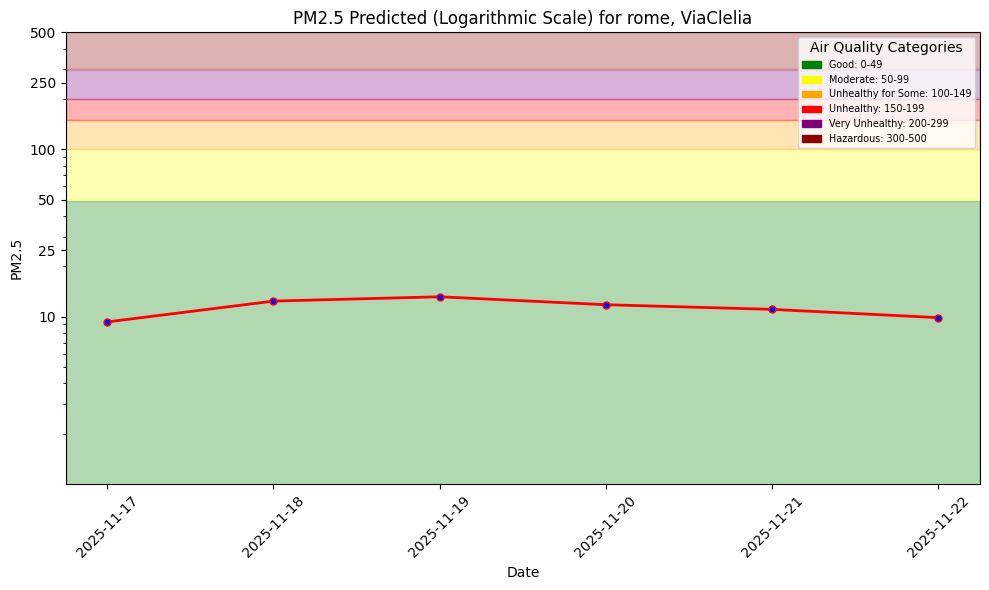

In [31]:
#Sensor 1
# Output filename
pred_file_path_s1 = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast_sensor1.png"
# Generate plot using your function
plt = util.plot_air_quality_forecast(city, street_1, batch_data_s1, pred_file_path_s1)
# Save the figure
plt.savefig(pred_file_path_s1, dpi=200, bbox_inches="tight")
# Optional: show each figure
plt.show()
# Close figure to avoid overlapping
plt.close()

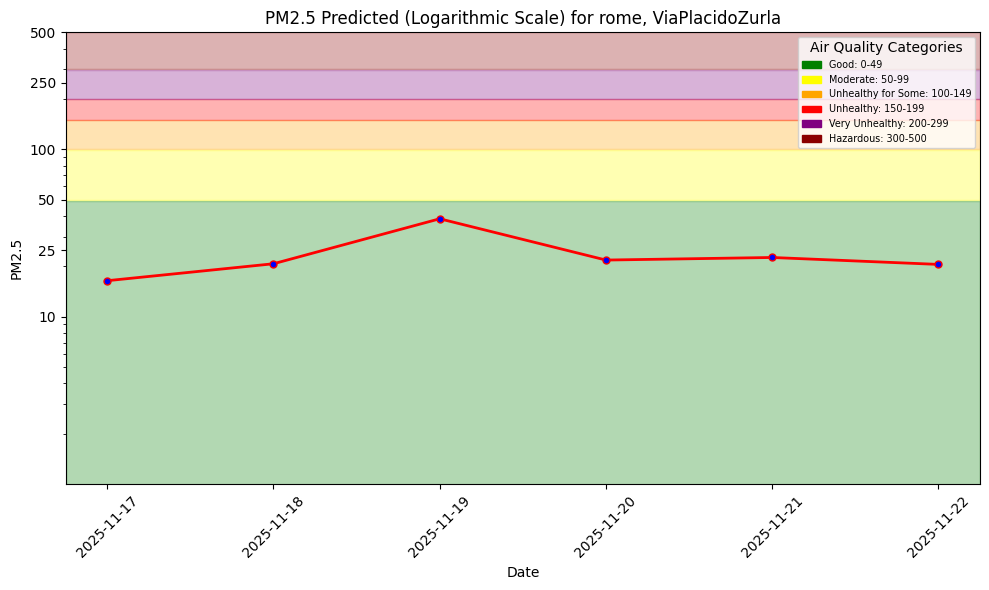

In [32]:
#Sensor 2
# Output filename
pred_file_path_s2 = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast_sensor2.png"
# Generate plot using your function
plt = util.plot_air_quality_forecast(city, street_2, batch_data_s2, pred_file_path_s2)
# Save the figure
plt.savefig(pred_file_path_s2, dpi=200, bbox_inches="tight")
# Optional: show each figure
plt.show()
# Close figure to avoid overlapping
plt.close()

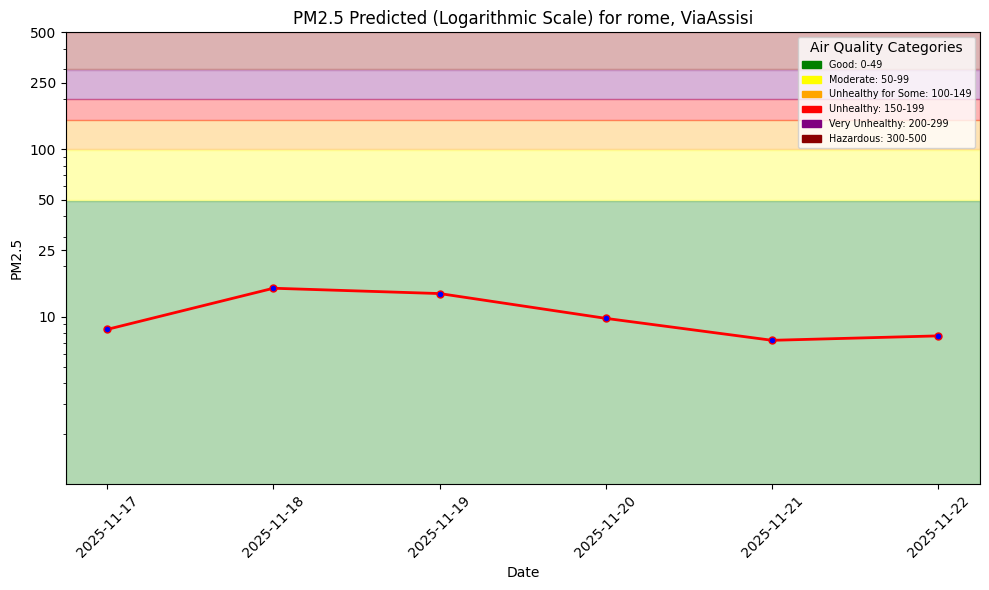

In [33]:
#Sensor 3
# Output filename
pred_file_path_s3 = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast_sensor3.png"
# Generate plot using your function
plt = util.plot_air_quality_forecast(city, street_3, batch_data_s3, pred_file_path_s3)
# Save the figure
plt.savefig(pred_file_path_s3, dpi=200, bbox_inches="tight")
# Optional: show each figure
plt.show()
# Close figure to avoid overlapping
plt.close()

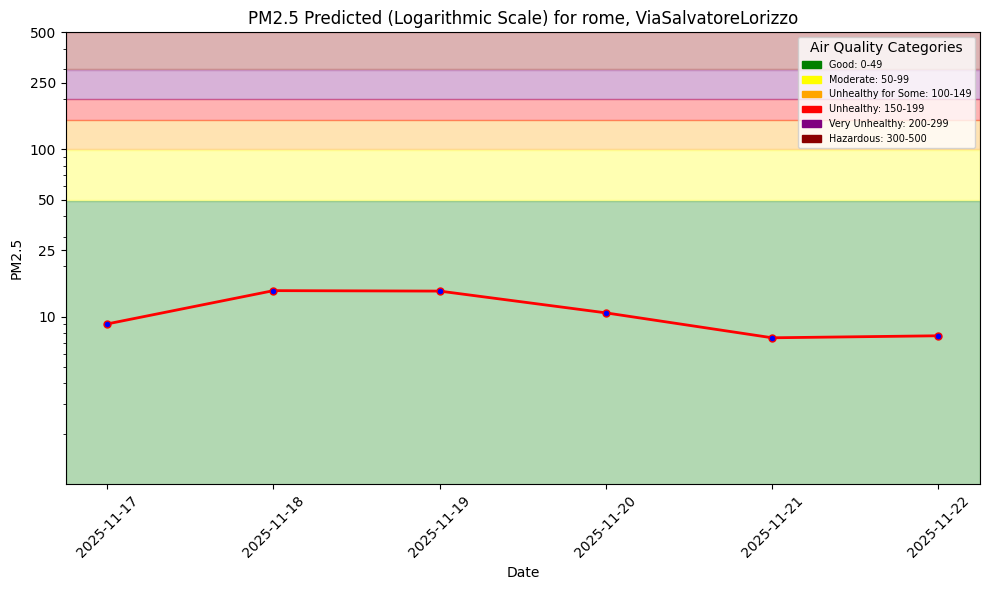

In [34]:
#Sensor 4
# Output filename
pred_file_path_s4 = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast_sensor4.png"
# Generate plot using your function
plt = util.plot_air_quality_forecast(city, street_4, batch_data_s4, pred_file_path_s4)
# Save the figure
plt.savefig(pred_file_path_s4, dpi=200, bbox_inches="tight")
# Optional: show each figure
plt.show()
# Close figure to avoid overlapping
plt.close()

In [35]:
# ORIGINAL CODE
#pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast.png"
#plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)

#plt.show()

In [36]:
# Get or create feature group
# Sensor 1
monitor_fg_1 = fs.get_or_create_feature_group(
    name='aq_predictions_lagged_s1',
    description='Air Quality prediction monitoring with lags',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

# Sensor 2
monitor_fg_2 = fs.get_or_create_feature_group(
    name='aq_predictions_lagged_s2',
    description='Air Quality prediction monitoring with lags',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

# Sensor 3
monitor_fg_3 = fs.get_or_create_feature_group(
    name='aq_predictions_lagged_s3',
    description='Air Quality prediction monitoring with lags',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

# Sensor 4
monitor_fg_4 = fs.get_or_create_feature_group(
    name='aq_predictions_lagged_s4',
    description='Air Quality prediction monitoring with lags',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [37]:
# Sensor 1
monitor_fg_1.insert(batch_data_s1, wait=True)

# Sensor 2
monitor_fg_2.insert(batch_data_s2, wait=True)

# Sensor 3
monitor_fg_3.insert(batch_data_s3, wait=True)

# Sensor 4
monitor_fg_4.insert(batch_data_s4, wait=True)

Uploading Dataframe: 100.00% |█| Rows 6/6 | Elapsed Time:


Launching job: aq_predictions_lagged_s1_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279151/jobs/named/aq_predictions_lagged_s1_1_offline_fg_materialization/executions
2025-11-16 19:33:36,392 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-16 19:33:39,593 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-16 19:35:15,486 INFO: Waiting for execution to finish. Current state: SUCCEEDING. Final status: UNDEFINED
2025-11-16 19:35:18,677 INFO: Waiting for execution to finish. Current state: FINISHED. Final status: SUCCEEDED
2025-11-16 19:35:19,134 INFO: Waiting for log aggregation to finish.
2025-11-16 19:35:19,136 INFO: Execution finished successfully.


Uploading Dataframe: 100.00% |█| Rows 6/6 | Elapsed Time:


Launching job: aq_predictions_lagged_s2_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279151/jobs/named/aq_predictions_lagged_s2_1_offline_fg_materialization/executions
2025-11-16 19:35:36,114 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-16 19:35:39,371 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-16 19:37:25,145 INFO: Waiting for execution to finish. Current state: FINISHED. Final status: SUCCEEDED
2025-11-16 19:37:25,632 INFO: Waiting for log aggregation to finish.
2025-11-16 19:37:25,634 INFO: Execution finished successfully.


Uploading Dataframe: 100.00% |█| Rows 6/6 | Elapsed Time:


Launching job: aq_predictions_lagged_s3_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279151/jobs/named/aq_predictions_lagged_s3_1_offline_fg_materialization/executions
2025-11-16 19:37:42,285 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2025-11-16 19:37:45,471 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-16 19:39:37,083 INFO: Waiting for execution to finish. Current state: SUCCEEDING. Final status: UNDEFINED
2025-11-16 19:39:40,263 INFO: Waiting for execution to finish. Current state: FINISHED. Final status: SUCCEEDED
2025-11-16 19:39:40,674 INFO: Waiting for log aggregation to finish.
2025-11-16 19:39:40,676 INFO: Execution finished successfully.


Uploading Dataframe: 100.00% |█| Rows 6/6 | Elapsed Time:


Launching job: aq_predictions_lagged_s4_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279151/jobs/named/aq_predictions_lagged_s4_1_offline_fg_materialization/executions
2025-11-16 19:39:57,316 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-16 19:40:03,683 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-16 19:41:52,549 INFO: Waiting for execution to finish. Current state: SUCCEEDING. Final status: UNDEFINED
2025-11-16 19:41:55,745 INFO: Waiting for execution to finish. Current state: FINISHED. Final status: SUCCEEDED
2025-11-16 19:41:56,145 INFO: Waiting for log aggregation to finish.
2025-11-16 19:41:56,146 INFO: Execution finished successfully.


(Job('aq_predictions_lagged_s4_1_offline_fg_materialization', 'SPARK'), None)

In [46]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
# Sensor 1
monitoring_df_s1 = monitor_fg_1.filter(monitor_fg_1.days_before_forecast_day == 1).read()

# Sensor 2
monitoring_df_s2 = monitor_fg_2.filter(monitor_fg_2.days_before_forecast_day == 1).read()

# Sensor 3
monitoring_df_s3 = monitor_fg_3.filter(monitor_fg_3.days_before_forecast_day == 1).read()

# Sensor 4
monitoring_df_s4 = monitor_fg_4.filter(monitor_fg_4.days_before_forecast_day == 1).read()
monitoring_df_s4

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.46s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.79s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.79s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.71s) 


,date,temperature_2m_mean,apparent_temperature_mean,dewpoint_2m_mean,precipitation_sum,rain_sum,snowfall_sum,wind_speed_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration,city,lag_1,lag_2,lag_3,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-16 00:00:00+00:00,21.700001,20.354990,12.266826,0.0,0.0,0.0,14.058450,166.675461,389.00,0.275921,rome,11.29,7.70,10.23,10.916657,ViaSalvatoreLorizzo,italy,1
1,2025-11-14 00:00:00+00:00,13.253333,12.498933,9.982501,0.0,0.0,0.0,11.341428,113.593491,9.14,1.475651,rome,7.70,10.23,13.47,10.693137,ViaSalvatoreLorizzo,italy,1
2,2025-11-15 00:00:00+00:00,20.950001,19.937057,13.145895,0.0,0.0,0.0,13.797912,187.495758,416.00,0.270081,rome,11.29,7.70,10.23,10.670869,ViaSalvatoreLorizzo,italy,1
3,2025-11-12 00:00:00+00:00,12.130416,10.948205,7.595001,0.0,0.0,0.0,7.452086,52.888248,10.43,1.458708,rome,13.47,8.13,6.35,14.087388,ViaSalvatoreLorizzo,italy,1
4,2025-11-13 00:00:00+00:00,12.613750,11.775219,8.897083,0.0,0.0,0.0,8.305396,63.237240,10.38,1.468767,rome,10.23,13.47,8.13,13.085180,ViaSalvatoreLorizzo,italy,1
5,2025-11-17 00:00:00+00:00,19.200001,17.112673,12.694678,0.1,0.1,0.0,20.124611,222.825241,370.00,0.234400,rome,11.29,7.70,10.23,9.053753,ViaSalvatoreLorizzo,italy,1


In [47]:
# Sensor 1
air_quality_fg_s1 = fs.get_feature_group(name='air_quality_lagged_sensor_1', version=1)
air_quality_df_s1 = air_quality_fg_s1.read()
air_quality_df_s1.sort_values(by=['date'])

# Sensor 2
air_quality_fg_s2 = fs.get_feature_group(name='air_quality_lagged_sensor_2', version=1)
air_quality_df_s2 = air_quality_fg_s2.read()
air_quality_df_s2.sort_values(by=['date'])

# Sensor 3
air_quality_fg_s3 = fs.get_feature_group(name='air_quality_lagged_sensor_3', version=1)
air_quality_df_s3 = air_quality_fg_s3.read()
air_quality_df_s3.sort_values(by=['date'])

# Sensor 4
air_quality_fg_s4 = fs.get_feature_group(name='air_quality_lagged_sensor_4', version=1)
air_quality_df_s4 = air_quality_fg_s4.read()
air_quality_df_s4.sort_values(by=['date'])

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.09s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.92s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.81s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.83s) 


,date,pm25,lag_1,lag_2,lag_3,country,city,street,url
452,2020-04-07 00:00:00+00:00,7.56,6.07,6.24,30.26,italy,rome,ViaSalvatoreLorizzo,https://api.waqi.info/feed/A112915/
776,2020-04-08 00:00:00+00:00,9.32,7.56,6.07,6.24,italy,rome,ViaSalvatoreLorizzo,https://api.waqi.info/feed/A112915/
459,2020-04-09 00:00:00+00:00,8.50,9.32,7.56,6.07,italy,rome,ViaSalvatoreLorizzo,https://api.waqi.info/feed/A112915/
127,2020-04-10 00:00:00+00:00,12.15,8.50,9.32,7.56,italy,rome,ViaSalvatoreLorizzo,https://api.waqi.info/feed/A112915/
1728,2020-04-11 00:00:00+00:00,12.60,12.15,8.50,9.32,italy,rome,ViaSalvatoreLorizzo,https://api.waqi.info/feed/A112915/
...,...,...,...,...,...,...,...,...,...
807,2025-11-11 00:00:00+00:00,13.47,8.13,6.35,9.50,italy,rome,ViaSalvatoreLorizzo,https://api.waqi.info/feed/A112915/
1674,2025-11-12 00:00:00+00:00,10.23,13.47,8.13,6.35,italy,rome,ViaSalvatoreLorizzo,https://api.waqi.info/feed/A112915/
499,2025-11-13 00:00:00+00:00,7.70,10.23,13.47,8.13,italy,rome,ViaSalvatoreLorizzo,https://api.waqi.info/feed/A112915/
1634,2025-11-14 00:00:00+00:00,11.29,7.70,10.23,13.47,italy,rome,ViaSalvatoreLorizzo,https://api.waqi.info/feed/A112915/


### Sensor 1

In [56]:
outcome_df_s1 = air_quality_df_s1[['date', 'pm25']]
preds_df_s1 =  monitoring_df_s1[['date', 'predicted_pm25']]

hindcast_df_s1 = pd.merge(preds_df_s1, outcome_df_s1, on="date")
hindcast_df_s1 = hindcast_df_s1.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df_s1) == 0:
    hindcast_df_s1 = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df_s1, monitor_fg_1, retrieved_xgboost_model_s1)
hindcast_df_s1

,date,predicted_pm25,pm25
0,2025-11-12 00:00:00+00:00,15.133908,8.88
2,2025-11-13 00:00:00+00:00,11.025128,9.75
1,2025-11-14 00:00:00+00:00,11.740469,9.15


### Sensor 2

In [57]:
outcome_df_s2 = air_quality_df_s2[['date', 'pm25']]
preds_df_s2 =  monitoring_df_s2[['date', 'predicted_pm25']]

hindcast_df_s2 = pd.merge(preds_df_s2, outcome_df_s2, on="date")
hindcast_df_s2 = hindcast_df_s2.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df_s2) == 0:
    hindcast_df_s2 = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df_s2, monitor_fg_2, retrieved_xgboost_model_s2)
hindcast_df_s2

,date,predicted_pm25,pm25
2,2025-11-12 00:00:00+00:00,99.132545,15.18
0,2025-11-13 00:00:00+00:00,12.899201,11.93
4,2025-11-14 00:00:00+00:00,14.513421,11.45
1,2025-11-15 00:00:00+00:00,10.823382,19.83
3,2025-11-15 00:00:00+00:00,10.823382,19.83


### Sensor 3

In [58]:
outcome_df_s3 = air_quality_df_s3[['date', 'pm25']]
preds_df_s3 =  monitoring_df_s3[['date', 'predicted_pm25']]

hindcast_df_s3 = pd.merge(preds_df_s3, outcome_df_s3, on="date")
hindcast_df_s3 = hindcast_df_s3.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df_s3) == 0:
    hindcast_df_s3 = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df_s3, monitor_fg_3, retrieved_xgboost_model_s3)
hindcast_df_s3

,date,predicted_pm25,pm25
3,2025-11-12 00:00:00+00:00,13.578762,3.14
2,2025-11-13 00:00:00+00:00,8.964570,6.87
4,2025-11-14 00:00:00+00:00,9.858328,7.30
5,2025-11-15 00:00:00+00:00,9.349227,9.59
0,2025-11-16 00:00:00+00:00,7.524848,29.00
1,2025-11-16 00:00:00+00:00,7.524848,26.00


### Sensor 4

In [59]:
outcome_df_s4 = air_quality_df_s4[['date', 'pm25']]
preds_df_s4 =  monitoring_df_s4[['date', 'predicted_pm25']]

hindcast_df_s4 = pd.merge(preds_df_s4, outcome_df_s4, on="date")
hindcast_df_s4 = hindcast_df_s4.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df_s4) == 0:
    hindcast_df_s4 = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df_s4, monitor_fg_4, retrieved_xgboost_model_s4)
hindcast_df_s4

,date,predicted_pm25,pm25
2,2025-11-12 00:00:00+00:00,14.087388,10.23
3,2025-11-13 00:00:00+00:00,13.085180,7.70
0,2025-11-14 00:00:00+00:00,10.693137,11.29
1,2025-11-15 00:00:00+00:00,10.670869,15.15


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

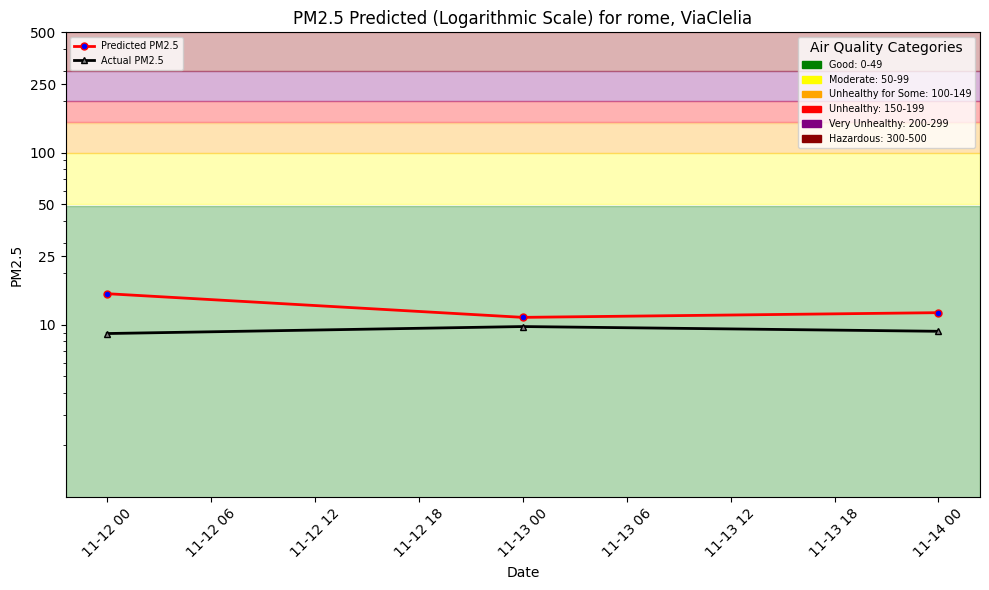

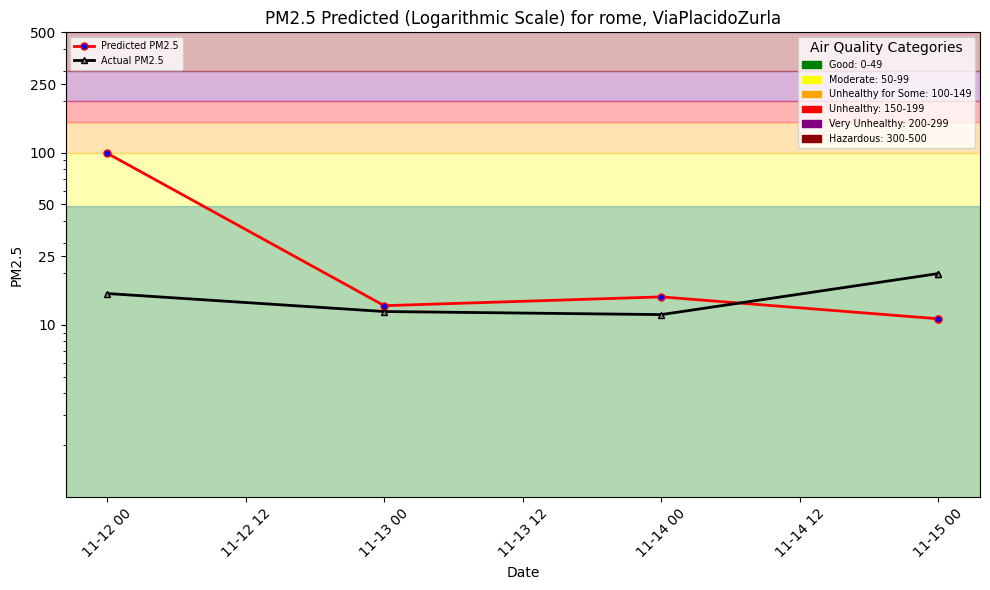

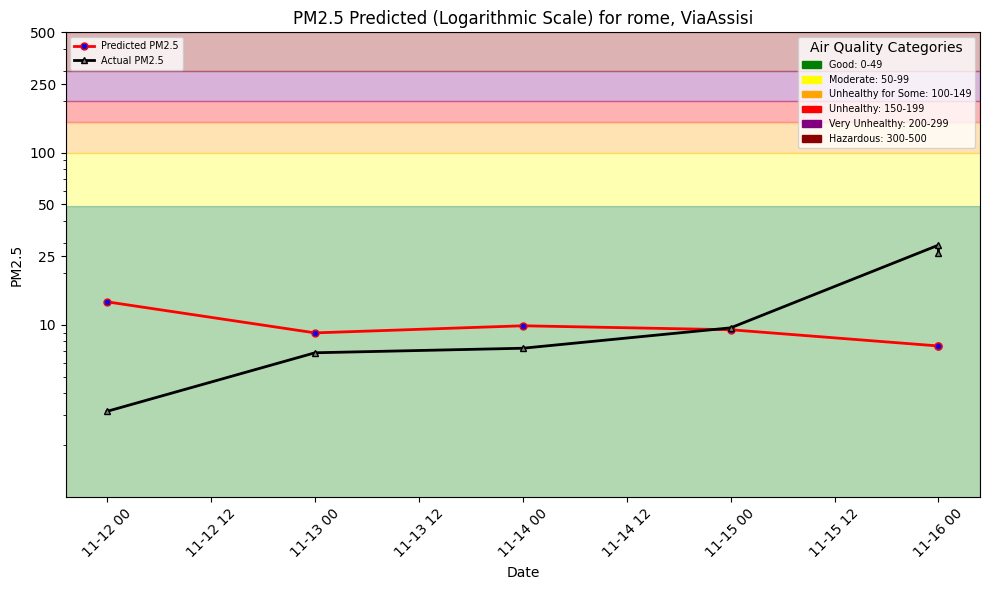

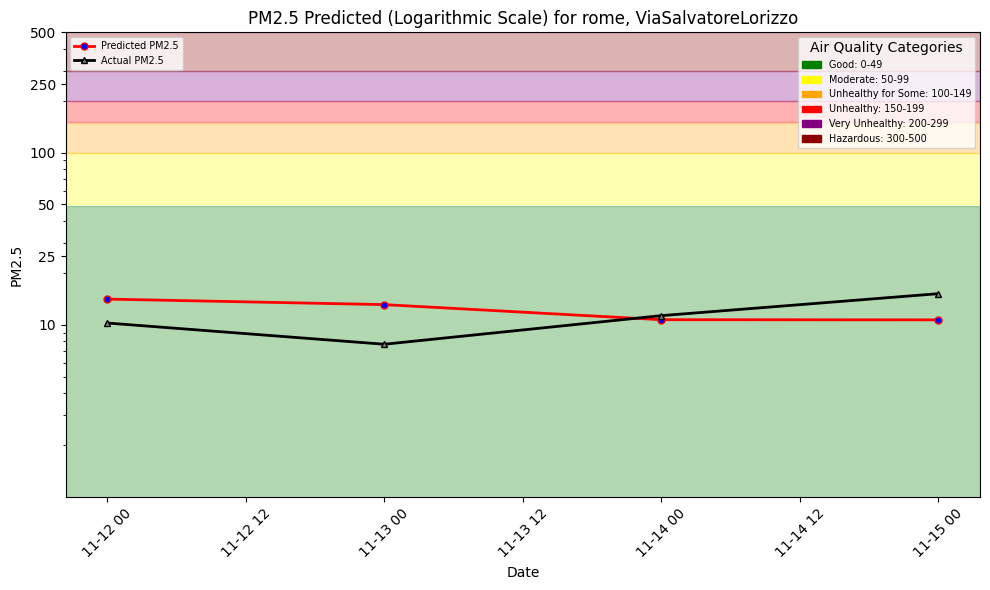

In [61]:
#Sensor 1
hindcast_file_path_s1 = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day_Sensor1.png"
plt = util.plot_air_quality_forecast(city, street_1, hindcast_df_s1, hindcast_file_path_s1, hindcast=True)
plt.show()

#Sensor 2
hindcast_file_path_s2 = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day_Sensor2.png"
plt = util.plot_air_quality_forecast(city, street_2, hindcast_df_s2, hindcast_file_path_s2, hindcast=True)
plt.show()

#Sensor 1
hindcast_file_path_s3 = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day_Sensor3.png"
plt = util.plot_air_quality_forecast(city, street_3, hindcast_df_s3, hindcast_file_path_s3, hindcast=True)
plt.show()

#Sensor 1
hindcast_file_path_s4 = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day_Sensor4.png"
plt = util.plot_air_quality_forecast(city, street_4, hindcast_df_s4, hindcast_file_path_s4, hindcast=True)
plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [62]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")

#Sensor_1
dataset_api.upload(pred_file_path_s1, f"Resources/airquality/{city}_{street_1}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path_s1, f"Resources/airquality/{city}_{street_1}_{str_today}", overwrite=True)

#Sensor_2
dataset_api.upload(pred_file_path_s2, f"Resources/airquality/{city}_{street_2}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path_s2, f"Resources/airquality/{city}_{street_2}_{str_today}", overwrite=True)

#Sensor_3
dataset_api.upload(pred_file_path_s3, f"Resources/airquality/{city}_{street_3}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path_s3, f"Resources/airquality/{city}_{street_3}_{str_today}", overwrite=True)

#Sensor_4
dataset_api.upload(pred_file_path_s4, f"Resources/airquality/{city}_{street_4}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path_s4, f"Resources/airquality/{city}_{street_4}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading /Users/karen/mlfs-book/docs/air-quality/assets/img/pm25_forecast_sensor1.png: 0.000%|          | 0/9…

Uploading /Users/karen/mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day_Sensor1.png: 0.000%|          …

Uploading /Users/karen/mlfs-book/docs/air-quality/assets/img/pm25_forecast_sensor2.png: 0.000%|          | 0/1…

Uploading /Users/karen/mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day_Sensor2.png: 0.000%|          …

Uploading /Users/karen/mlfs-book/docs/air-quality/assets/img/pm25_forecast_sensor3.png: 0.000%|          | 0/1…

Uploading /Users/karen/mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day_Sensor3.png: 0.000%|          …

Uploading /Users/karen/mlfs-book/docs/air-quality/assets/img/pm25_forecast_sensor4.png: 0.000%|          | 0/1…

Uploading /Users/karen/mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day_Sensor4.png: 0.000%|          …

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1279151/settings/fb/path/Resources/airquality


---